In [ ]:
!pip install opendatasets


In [ ]:
!pip install accelerate -U
!pip install transformers -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 3.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:

import torch
import torchvision

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import opendatasets as od

from PIL import Image
import os
import json
from transformers import AutoModel, AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel, BertConfig
import transformers

import accelerate
from torchvision import transforms
import torch.nn as nn
import torch
import csv


In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/trungit/wikiart25k'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading wikiart25k.zip to ./wikiart25k


100%|██████████| 7.74G/7.74G [04:25<00:00, 31.3MB/s]


In [ ]:
import os

# function to delete incorrectly encoded files

def delete_non_ascii_filenames(directory):
    count = 0
    for subdir, _, files in os.walk(directory):
        for file in files:
            try:
                file.encode('ascii')
            except UnicodeEncodeError:  # Filename is non-ASCII
                full_path = os.path.join(subdir, file)
                os.remove(full_path)  # Delete the file
                count += 1
                print(f"Deleted file: {full_path}")
    return count

# Use the function on your dataset directory and delete non-ASCII files
deleted_count = delete_non_ascii_filenames('wikiart25k')
print(f"Total deleted files: {deleted_count}")

Total deleted files: 0


In [ ]:
import csv
from torch.utils.data import Dataset

class MoodBoardDataset(Dataset):
    def __init__(self, csv_file):
        self.annotations = self._load_annotations(csv_file)
        self.texts = [row[3] for row in self.annotations]
    def _load_annotations(self, csv_file):
        with open(csv_file, 'r', newline='') as file:
            reader = csv.reader(file)
            # Skip the header if there is one
            next(reader, None)
            annotations = [row for row in reader]
        return annotations

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_info = self.annotations[idx]
        emotion = img_info[2]
        utterance = img_info[3]

        sample = {"utterance": utterance, "emotion": emotion}
        return sample

In [ ]:
def data_collate_fn(batch):
    # Extract emotions and utterances from the batch
    # Map emotions to numeric labels
    label_mapping = {
        "amusement": 0,
        "awe": 1,
        "contentment": 2,
        "excitement": 3,
        "anger": 4,
        "disgust": 5,
        "fear": 6,
        "sadness": 7,
        "something else": 8
    }
    #print(batch)
    emotion = [label_mapping[sample['emotion']] for sample in batch]
    labels = torch.tensor(emotion, dtype=torch.long).detach()

    texts = [sample['utterance'] for sample in batch]

    tokenized_texts = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    return {
        "input_ids": tokenized_texts['input_ids'],
        "labels": labels
    }

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ayoubkirouane/BERT-Emotions-Classifier")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import pandas as pd
# Load and process data
data = pd.read_csv('trimmed_valid_images.csv')
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
train_set.to_csv('train_data.csv', index=False)
test_set.to_csv('test_data.csv', index=False)

In [ ]:
train_dataset = MoodBoardDataset(csv_file='train_data.csv')

test_dataset = MoodBoardDataset(csv_file='test_data.csv')
# dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, collate_fn=data_collate_fn)

In [1]:
# for i in range(len(test_dataset)):
#     sample = train_dataset[i]
#     print(f"Sample {i+1}:")
#     print("Emotion:", sample['emotion'])
#     print("Utterance:", sample['utterance'])
#     print("")

In [ ]:
class TextOnlyBertModel(BertModel):
    def __init__(self, config, num_classes):
        super().__init__(config)
        self.bert_model = AutoModel.from_pretrained("ayoubkirouane/BERT-Emotions-Classifier", output_hidden_states=True)
        self.classifier = nn.Linear(config.hidden_size, num_classes)
        # self.dropout = nn.Dropout(p=0.5)
        # self.activation = nn.ReLU()

        self.loss_fct = nn.CrossEntropyLoss()


    def forward(self, input_ids=None, attention_mask=None, labels=None):
        # Forward pass through BERT
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)

        # Get pooled output (CLS token representation)
        pooled_output = outputs.pooler_output

        # Apply dropout
        # pooled_output = self.dropout(pooled_output)
        # pooled_output = self.activation(pooled_output)

        logits = self.classifier(pooled_output)
        outputs = {'logits': logits}
        if labels is not None:
          loss = self.loss_fct(logits,labels.view(-1))
          outputs ['loss'] = loss

        return outputs


In [ ]:
config = BertConfig.from_pretrained('bert-base-uncased')

model = TextOnlyBertModel(config, num_classes=9)

In [ ]:
ARTEMIS_EMOTIONS = ['amusement', 'awe', 'contentment', 'excitement',
                    'anger', 'disgust',  'fear', 'sadness', 'something else']

EMOTION_TO_IDX = {e: i for i, e in enumerate(ARTEMIS_EMOTIONS)}


IDX_TO_EMOTION = {EMOTION_TO_IDX[e]: e for e in EMOTION_TO_IDX}

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
save_dir = './confusion_matrices'


def compute_metrics(p):
    print(p.label_ids)
    print(p.label_ids.size)

    preds = np.argmax(p.predictions, axis=1)
    print(preds)
    accuracy = accuracy_score(p.label_ids, preds)

    cm = confusion_matrix(p.label_ids, preds)

    # Plot confusion matrix with labels and color highlighting
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=IDX_TO_EMOTION.values(), yticklabels=IDX_TO_EMOTION.values())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, 'confusion_matrix.png')
        plt.savefig(save_path)
        print(f"Confusion matrix saved at: {save_path}")


    #texts = p.dataset.texts

    # for i in range(len(p.label_ids)):
    #     #print("Utterance:", texts[i])
    #     print("Correct Emotion:", IDX_TO_EMOTION[p.label_ids[i]])
    #     print("Predicted Emotion:", IDX_TO_EMOTION[preds[i]])
    #     print("-------")
    print("Accuracy:", accuracy)

    return {"accuracy": accuracy}

Epoch,Training Loss,Validation Loss,Accuracy
1,0.269800,1.578374,0.613902
2,0.395400,1.481157,0.611402
3,0.358600,1.525971,0.615192
4,0.392200,1.521636,0.611483
5,0.376400,1.556668,0.612289
6,0.444000,1.517824,0.612451
7,0.418900,1.514678,0.614950
8,0.406000,1.524942,0.613499
9,0.396400,1.526719,0.613176
10,0.394200,1.529528,0.613257


[6 1 3 ... 1 8 1]
12401
[6 2 2 ... 1 8 2]
Confusion matrix saved at: ./confusion_matrices/confusion_matrix.png
Accuracy: 0.6139021046689783
[6 1 3 ... 1 8 1]
12401
[6 3 2 ... 1 5 2]
Confusion matrix saved at: ./confusion_matrices/confusion_matrix.png
Accuracy: 0.6114023062656238
[6 1 3 ... 1 8 1]
12401
[6 3 2 ... 1 5 2]
Confusion matrix saved at: ./confusion_matrices/confusion_matrix.png
Accuracy: 0.6151923231997419
[6 1 3 ... 1 8 1]
12401
[6 3 2 ... 1 5 2]
Confusion matrix saved at: ./confusion_matrices/confusion_matrix.png
Accuracy: 0.6114829449237965
[6 1 3 ... 1 8 1]
12401
[6 0 2 ... 1 5 2]
Confusion matrix saved at: ./confusion_matrices/confusion_matrix.png
Accuracy: 0.6122893315055238
[6 1 3 ... 1 8 1]
12401
[6 3 2 ... 1 5 2]
Confusion matrix saved at: ./confusion_matrices/confusion_matrix.png
Accuracy: 0.6124506088218692
[6 1 3 ... 1 8 1]
12401
[6 3 2 ... 1 5 2]
Confusion matrix saved at: ./confusion_matrices/confusion_matrix.png
Accuracy: 0.6149504072252238
[6 1 3 ... 1 8 1]
12

[6 1 3 ... 1 8 1]
12401
[6 3 2 ... 1 5 2]
Confusion matrix saved at: ./confusion_matrices/confusion_matrix.png
Accuracy: 0.6114023062656238


('./best_model_text_only4/tokenizer_config.json',
 './best_model_text_only4/special_tokens_map.json',
 './best_model_text_only4/vocab.txt',
 './best_model_text_only4/added_tokens.json',
 './best_model_text_only4/tokenizer.json')

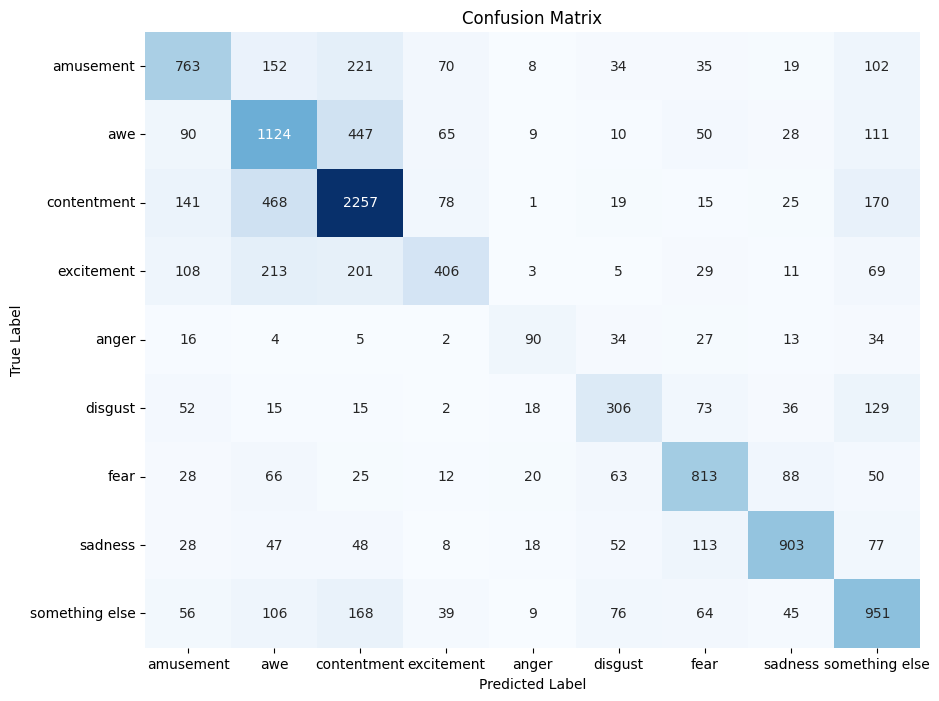

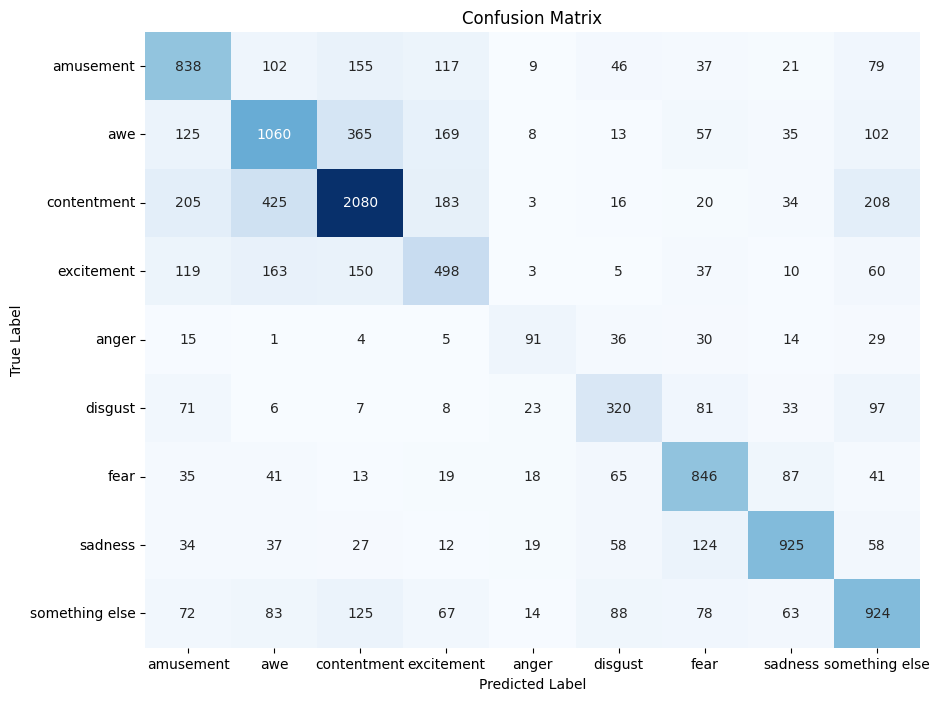

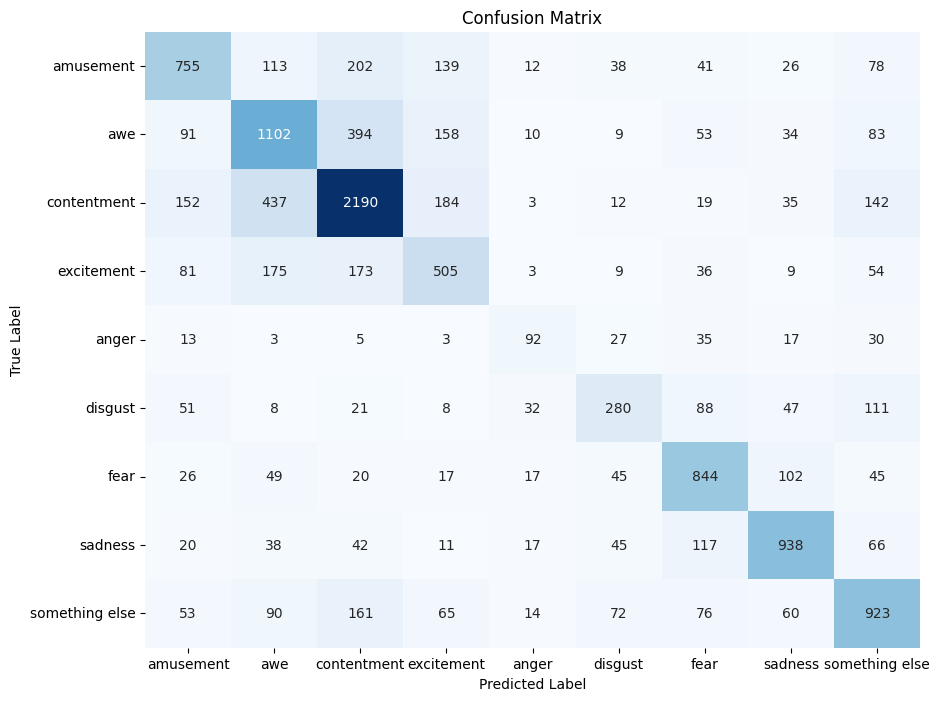

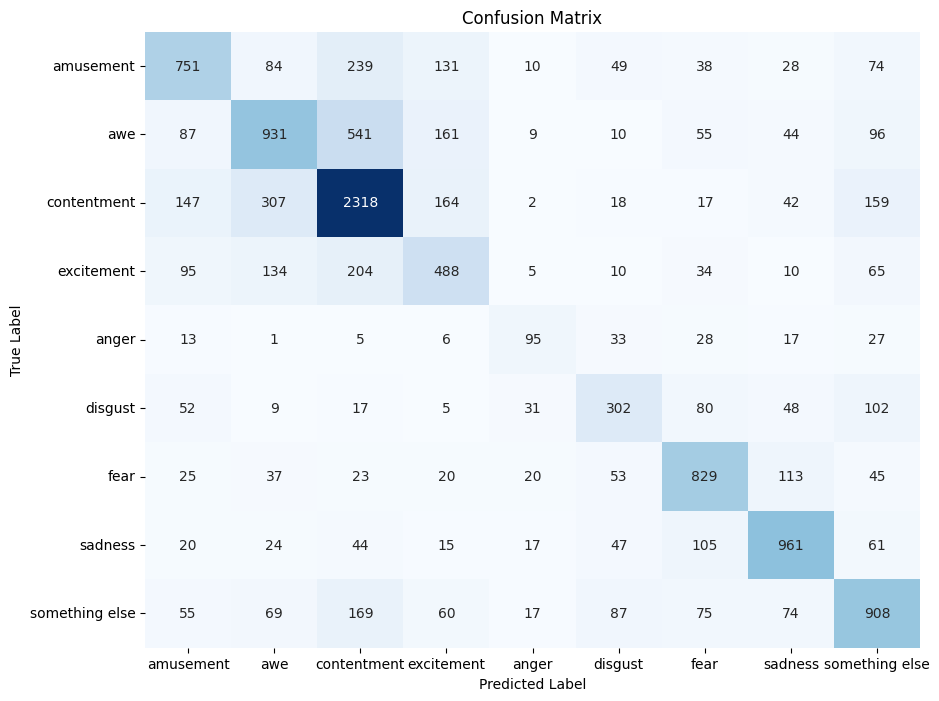

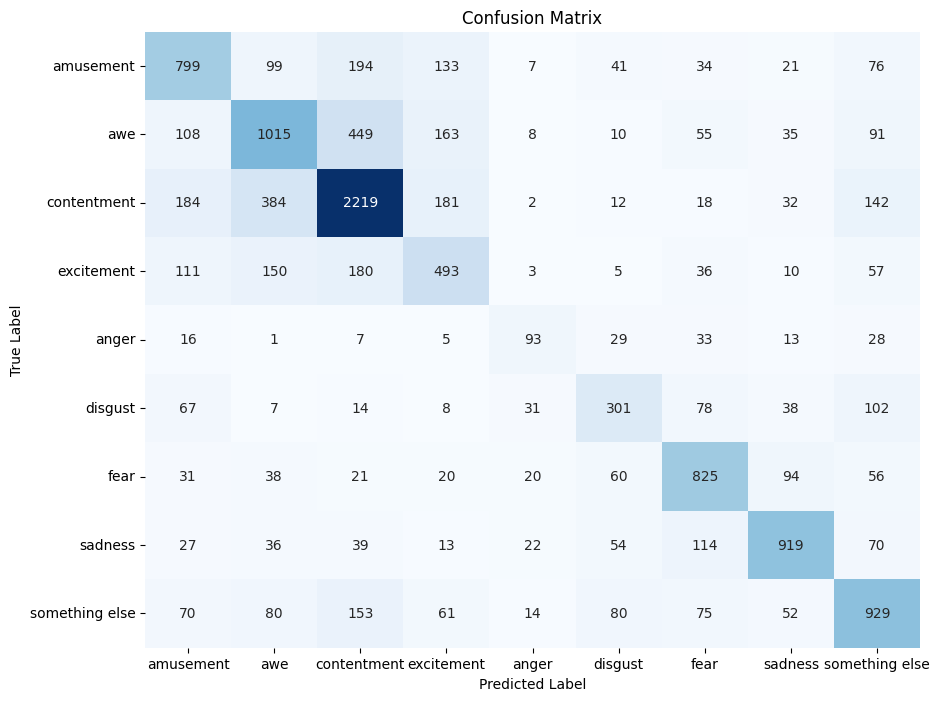

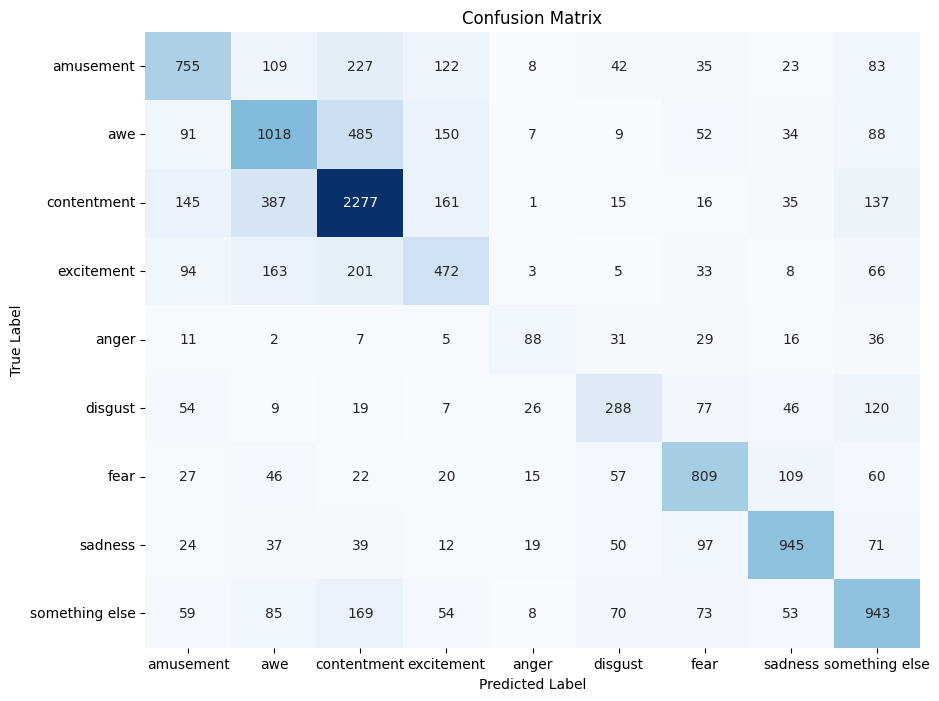

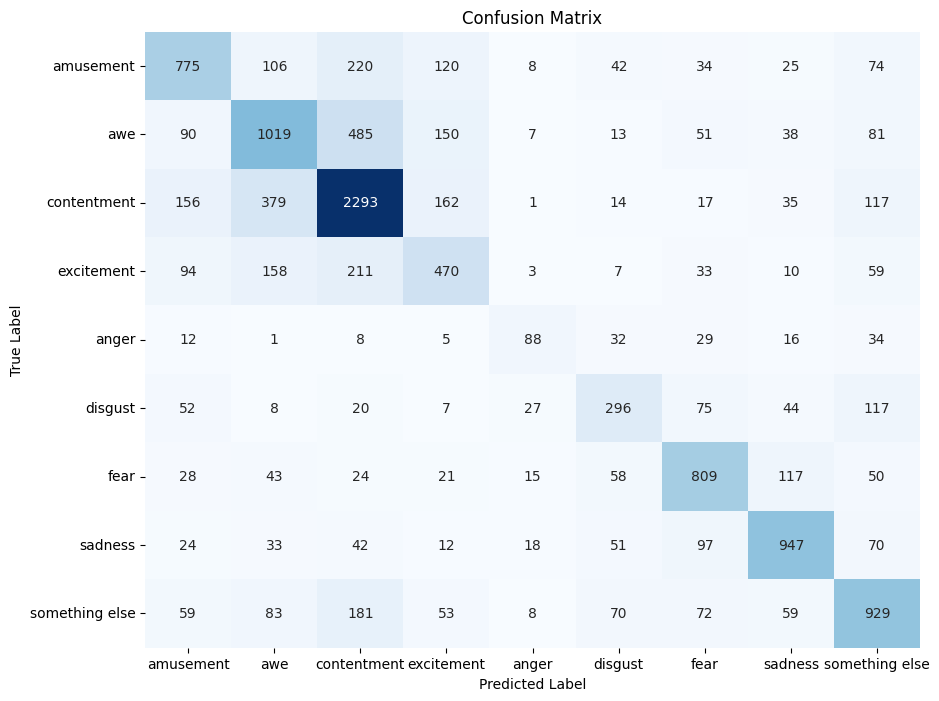

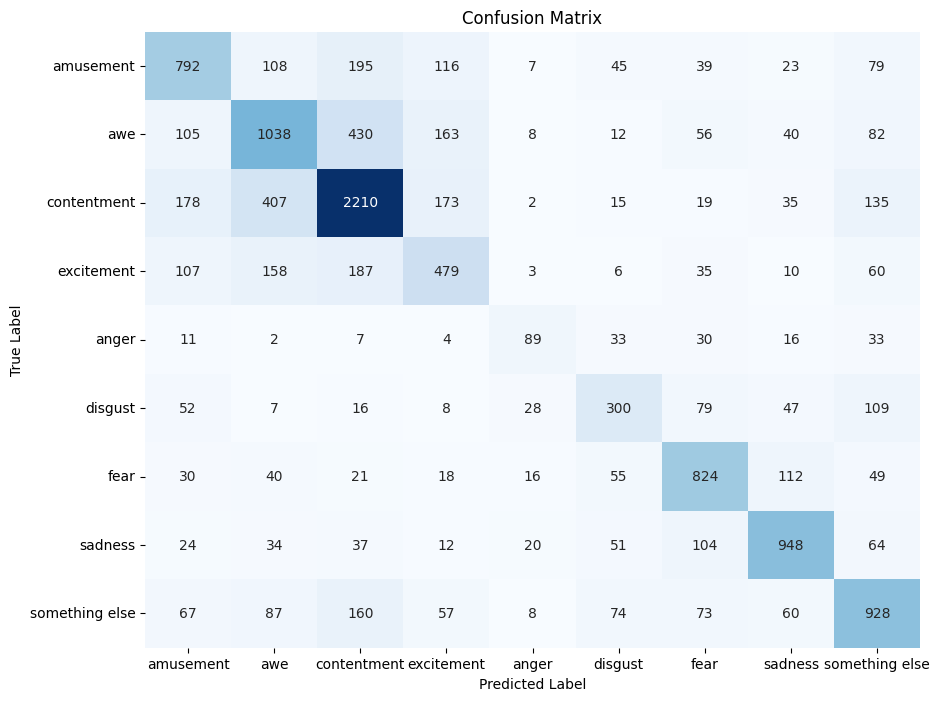

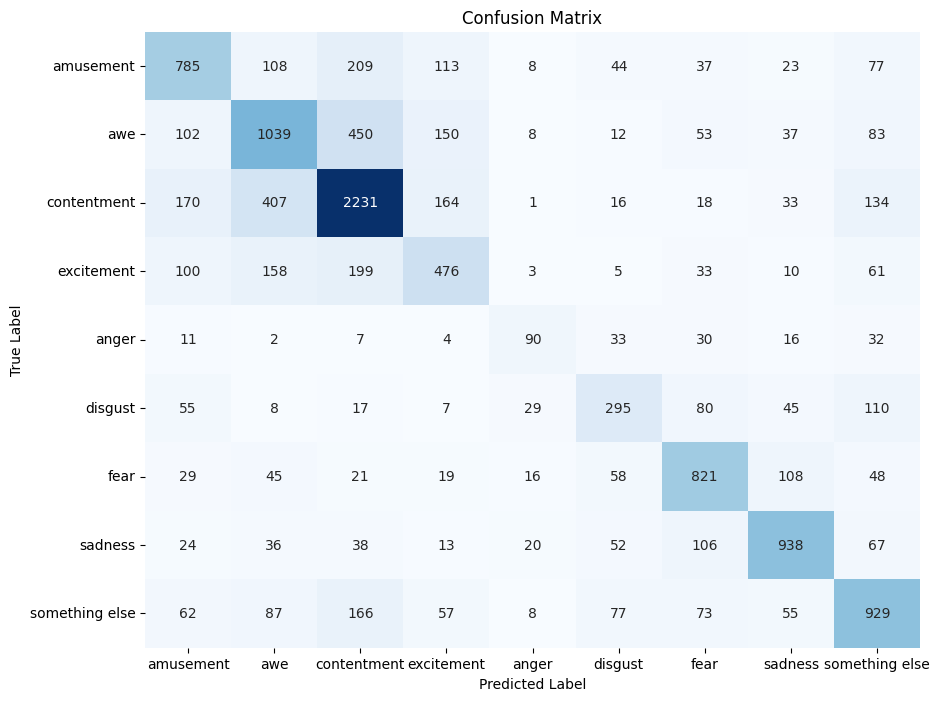

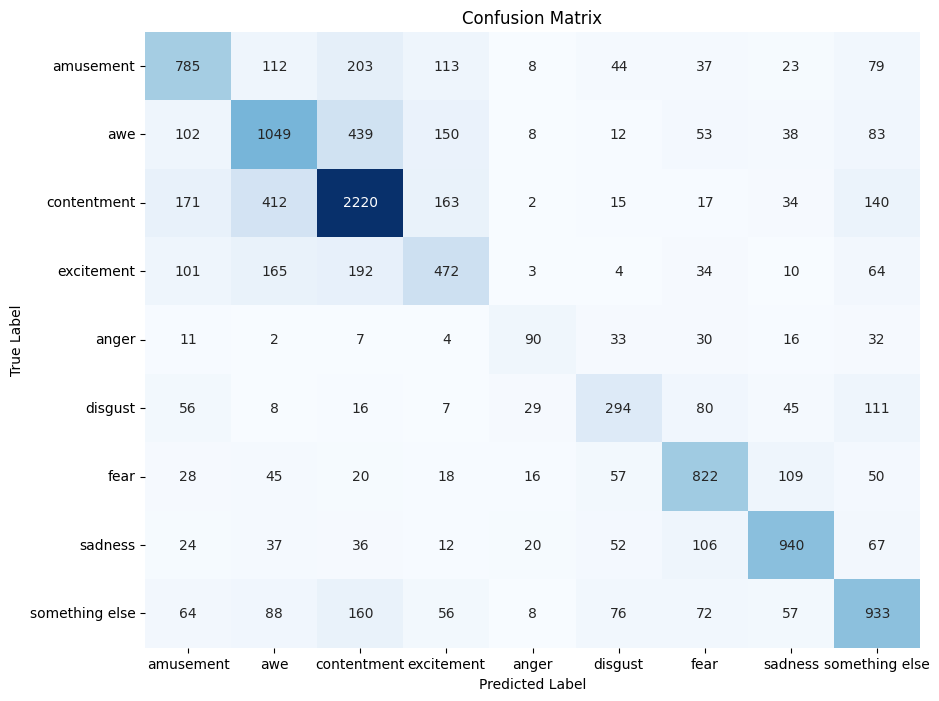

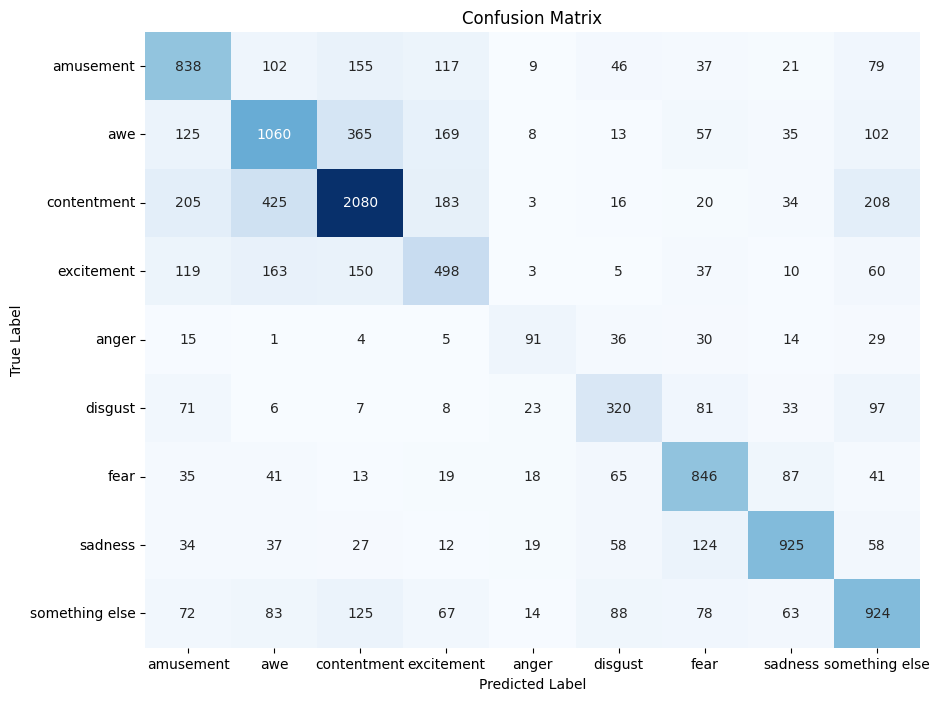

In [ ]:
# Training arguments
training_args = TrainingArguments(
    num_train_epochs=10,
    learning_rate=5e-6,
    weight_decay=0.01,
    logging_dir='./logs',
    output_dir='/results',
    lr_scheduler_type="cosine",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    remove_unused_columns=False,
    load_best_model_at_end=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Specify your training dataset
    eval_dataset=test_dataset,
    # optimizers=(optimizer, scheduler),
    data_collator=data_collate_fn,
    compute_metrics=compute_metrics,
)

# Train and evaluate the model
trainer.train()
trainer.evaluate()

# Save the model
model_path = './best_model_text_only4'
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)